In [32]:
from PIL import Image
from matplotlib import pyplot as plt
from os_paths import path_to_data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pdb
from skimage import color
from lab_utils import *
import time

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:",device)
latent_dim = 64
beta = 1

Using device: cuda


In [53]:
class FfhqDataset(Dataset):
    def __init__(self, root_dir, transform=None, colorchannels='ab', cacheing=True, cachelim=20000):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = os.listdir(root_dir)[0:20000]
        #a dictionary that prevents us from doing more compute than is necessary
        # preprocessing a batch takes about 5x as long as actually training it
        self.cacheing = cacheing
        self.cachelim = cachelim
        self.already_seen_images = {}
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image_path = self.image_paths[idx]
        
        # doing this is about 1000x faster than loading an image
        if self.cacheing and image_path in self.already_seen_images:
            return self.already_seen_images[image_path]
        
        img_name = os.path.join(self.root_dir, self.image_paths[idx])
        image = Image.open(img_name).convert('RGB')
        image = np.array(image) #go from PIL image to nparray so that rgb2lab will work
        image = color.rgb2lab(image).astype(np.float32)
        if self.transform:
            image = self.transform(image)
            
        # scale so that values are between 0 and 1
        image = scale_lab(image)
        
        if self.cacheing == True and len(self.already_seen_images) < self.cachelim:
            self.already_seen_images[image_path] = image
        return image
    
    def preshow_image(self,image):
        """
        input: torch.tensor in scaled CIELAB color space, (C, H, W)
        output: np array in RGB color space
        """
        image = image.numpy()
        image = descale_lab(image) 
        image = np.moveaxis(image, 0,-1) # Convert from (C, H, W) to (H, W, C) so imshow works
        image = color.lab2rgb(image, channel_axis=-1)
        image = (image * 255).astype(np.uint8)
        return image
    def show_grid(self,nrows, ncols):
        n = nrows * ncols
        images = [self[i] for i in range(n)]
        fig, axes = plt.subplots(nrows, ncols)
        for i, ax in enumerate(axes.flat):
            if i < len(images):
                image = self.preshow_image(images[i])
                ax.imshow(image)
                ax.axis('off')
        plt.show()
        
    def preprocess_everything(self):
        """
        preprocess everything up front
        images load about 1000x faster when preprocessed
        """
        t0 = time.time()
        n = len(self)
        print(f"Preprocessing {n} images")
        update_block = n // 100
        percent_complete = 0
        for i in range(n):
            if i % update_block == 0:
                percent_complete += 1
                print(f"{percent_complete}% complete")
            self[i]
        print(time.time() - t0,'seconds')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128),antialias=True),
    #transforms.Normalize((0.5,), (0.5,))
])

path_to_trn = os.path.join(path_to_data,'training')
path_to_tst = os.path.join(path_to_data,'test')
dataset = FfhqDataset(root_dir=path_to_trn, transform=transform, cacheing=True, cachelim=20000)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

tst_dataset = FfhqDataset(root_dir=path_to_tst, transform=transform)
tst_dataloader = DataLoader(tst_dataset, batch_size=32, shuffle=True)

In [54]:
#dataset.preprocess_everything()

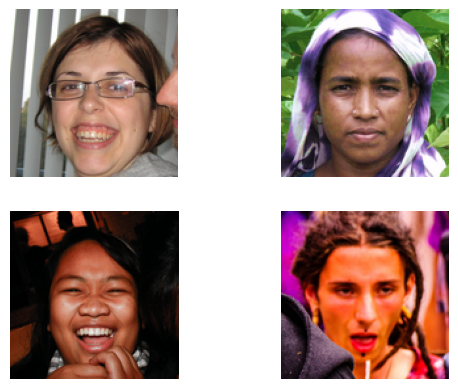

In [55]:
dataset.show_grid(2,2)

In [56]:
def display_tensor_as_image(image):
        image = dataset.preshow_image(image)
        pil_image = Image.fromarray(image)
        display(pil_image)
        return pil_image

In [57]:
class ColorEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(ColorEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(128*32*32, 512)
        self.fc21 = nn.Linear(512, latent_dim)
        self.fc22 = nn.Linear(512, latent_dim)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = x.view(-1, 128*32*32)
        x = nn.functional.relu(self.fc1(x))
        mean = self.fc21(x)
        logvar = self.fc22(x)
        return mean, logvar



In [58]:
class ColorDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(ColorDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 512)
        self.fc2 = nn.Linear(512, 128*32*32)
        self.conv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv3 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, z):
        z = nn.functional.relu(self.fc1(z))
        z = nn.functional.relu(self.fc2(z))
        z = z.view(-1, 128, 32, 32)
        z = nn.functional.relu(self.conv1(z))
        z = nn.functional.relu(self.conv2(z))
        x = torch.sigmoid(self.conv3(z))
        return x



In [59]:
class ColorVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ColorVAE, self).__init__()
        self.encoder = ColorEncoder(latent_dim)
        self.decoder = ColorDecoder(latent_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = eps * std + mean
        return z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu,logvar

def vae_loss(recon_x, x, mu, logvar, criterion,beta=beta):
    BCE = criterion(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

In [60]:
def show_example(model,idx=0,dataset=dataset):
    model.eval()
    example_batch = torch.Tensor.expand(dataset[idx],1,3,128,128).to(device)
    with torch.no_grad():
        example_output = model.forward(example_batch)
    ret = {
        'original':display_tensor_as_image(dataset[idx]),
        'recon':display_tensor_as_image(example_output[0][0].to('cpu'))
    }
    return ret

In [61]:
def generate_samples_from_vae(model,device=device,latent_dim=latent_dim,num_samples=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decoder(z).cpu()
    sample_images = [display_tensor_as_image(sample) for sample in samples]
    return sample_images

In [62]:
cvae = ColorVAE(latent_dim).to(device)

In [63]:
def eval_tst_vae_loss(model,criterion,dataloader=tst_dataloader):
    tst_loss = 0
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            batch_loss = vae_loss(recon_batch, data, mu, logvar, criterion)   
            tst_loss += batch_loss
    return tst_loss / len(tst_dataloader.dataset)

In [64]:
learning_rate=1e-3
num_epochs=300
num_epochs_completed = 0

optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
criterion = nn.BCELoss(reduction='sum')

Epoch 1/300, Train Loss: 32603.7171, Test loss: 32364.9648
Trn Recon example:


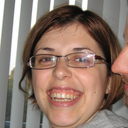

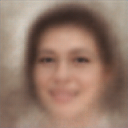

Tst Recon example:


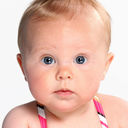

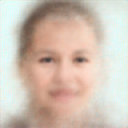

Generated example:


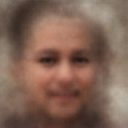

Epoch 2/300, Train Loss: 32198.3885, Test loss: 32253.0898
Trn Recon example:


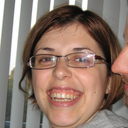

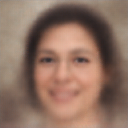

Tst Recon example:


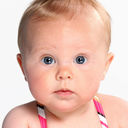

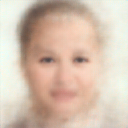

Generated example:


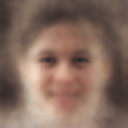

Epoch 3/300, Train Loss: 32116.6905, Test loss: 32198.7695
Trn Recon example:


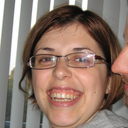

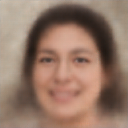

Tst Recon example:


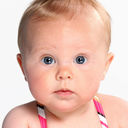

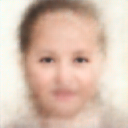

Generated example:


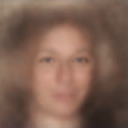

Epoch 4/300, Train Loss: 32071.2476, Test loss: 32169.8340
Trn Recon example:


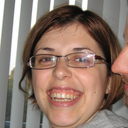

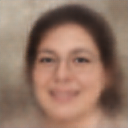

Tst Recon example:


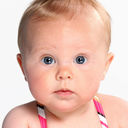

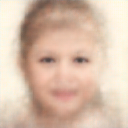

Generated example:


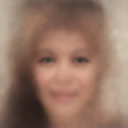

Epoch 5/300, Train Loss: 32041.8923, Test loss: 32152.3848
Trn Recon example:


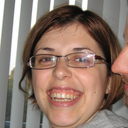

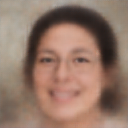

Tst Recon example:


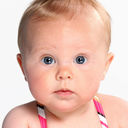

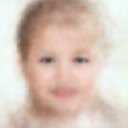

Generated example:


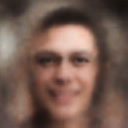

Epoch 6/300, Train Loss: 32008.4220, Test loss: 32119.2559
Trn Recon example:


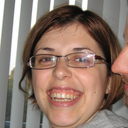

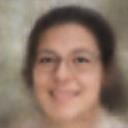

Tst Recon example:


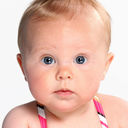

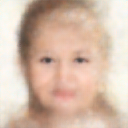

Generated example:


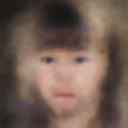

Epoch 7/300, Train Loss: 31971.8900, Test loss: 32102.5117
Trn Recon example:


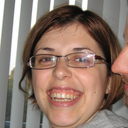

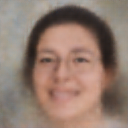

Tst Recon example:


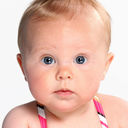

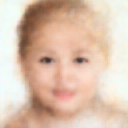

Generated example:


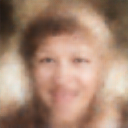

Epoch 8/300, Train Loss: 31951.4785, Test loss: 32106.1016
Trn Recon example:


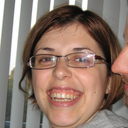

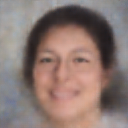

Tst Recon example:


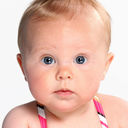

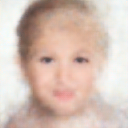

Generated example:


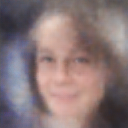

Epoch 9/300, Train Loss: 31933.2477, Test loss: 32094.8066
Trn Recon example:


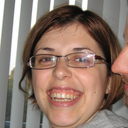

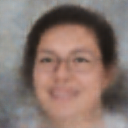

Tst Recon example:


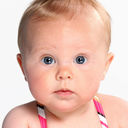

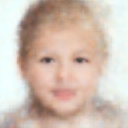

Generated example:


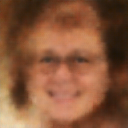

Epoch 10/300, Train Loss: 31915.6911, Test loss: 32086.1777
Trn Recon example:


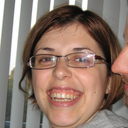

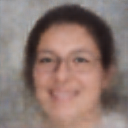

Tst Recon example:


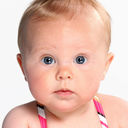

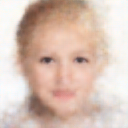

Generated example:


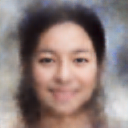

Epoch 11/300, Train Loss: 31899.4528, Test loss: 32080.2734
Trn Recon example:


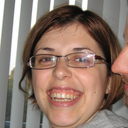

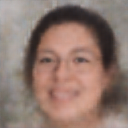

Tst Recon example:


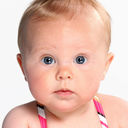

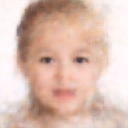

Generated example:


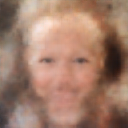

Epoch 12/300, Train Loss: 31883.0423, Test loss: 32085.9102
Trn Recon example:


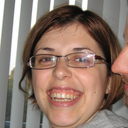

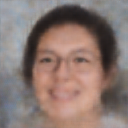

Tst Recon example:


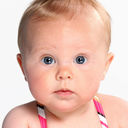

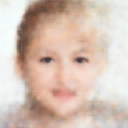

Generated example:


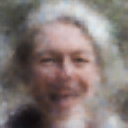

Epoch 13/300, Train Loss: 31865.7596, Test loss: 32089.7070
Trn Recon example:


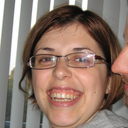

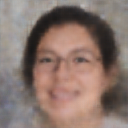

Tst Recon example:


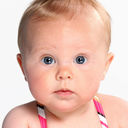

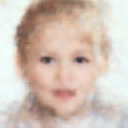

Generated example:


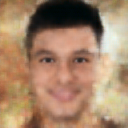

Epoch 14/300, Train Loss: 31849.4064, Test loss: 32088.0547
Trn Recon example:


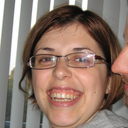

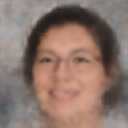

Tst Recon example:


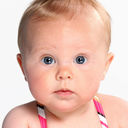

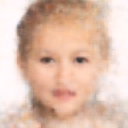

Generated example:


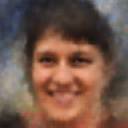

Epoch 15/300, Train Loss: 31833.5212, Test loss: 32095.4473
Trn Recon example:


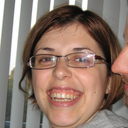

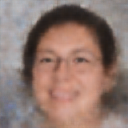

Tst Recon example:


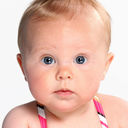

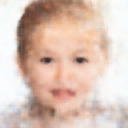

Generated example:


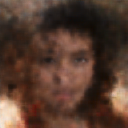

Epoch 16/300, Train Loss: 31819.7395, Test loss: 32097.7324
Trn Recon example:


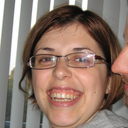

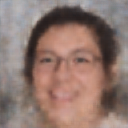

Tst Recon example:


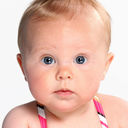

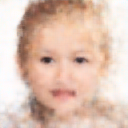

Generated example:


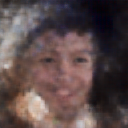

Epoch 17/300, Train Loss: 31802.4138, Test loss: 32107.0977
Trn Recon example:


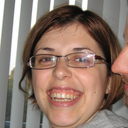

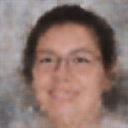

Tst Recon example:


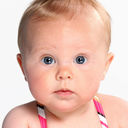

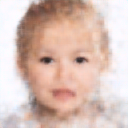

Generated example:


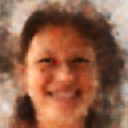

Epoch 18/300, Train Loss: 31789.7564, Test loss: 32115.7871
Trn Recon example:


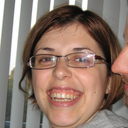

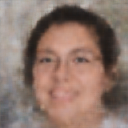

Tst Recon example:


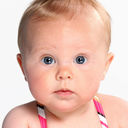

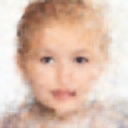

Generated example:


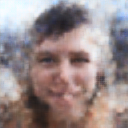

Epoch 19/300, Train Loss: 31775.4555, Test loss: 32119.0469
Trn Recon example:


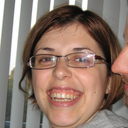

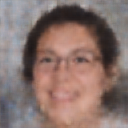

Tst Recon example:


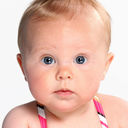

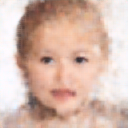

Generated example:


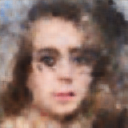

Epoch 20/300, Train Loss: 31761.4959, Test loss: 32124.3867
Trn Recon example:


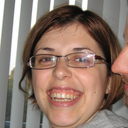

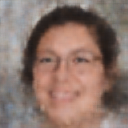

Tst Recon example:


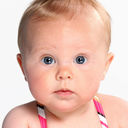

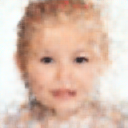

Generated example:


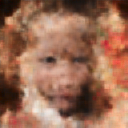

Epoch 21/300, Train Loss: 31749.4962, Test loss: 32135.2637
Trn Recon example:


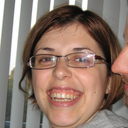

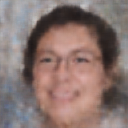

Tst Recon example:


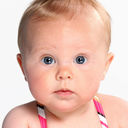

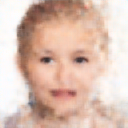

Generated example:


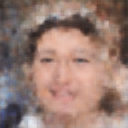

Epoch 22/300, Train Loss: 31736.8311, Test loss: 32141.7793
Trn Recon example:


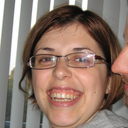

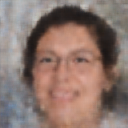

Tst Recon example:


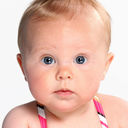

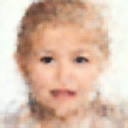

Generated example:


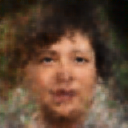

Epoch 23/300, Train Loss: 31726.3519, Test loss: 32136.8223
Trn Recon example:


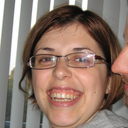

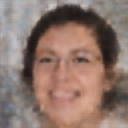

Tst Recon example:


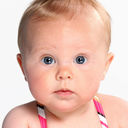

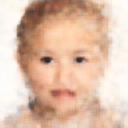

Generated example:


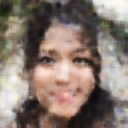

Epoch 24/300, Train Loss: 31715.8269, Test loss: 32143.1914
Trn Recon example:


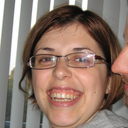

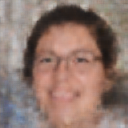

Tst Recon example:


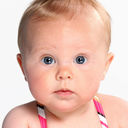

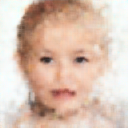

Generated example:


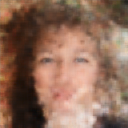

Epoch 25/300, Train Loss: 31705.1387, Test loss: 32156.7109
Trn Recon example:


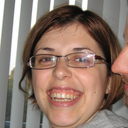

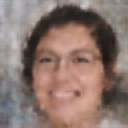

Tst Recon example:


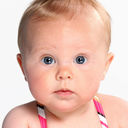

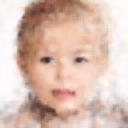

Generated example:


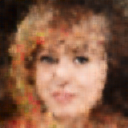

Epoch 26/300, Train Loss: 31695.6854, Test loss: 32158.1387
Trn Recon example:


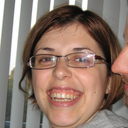

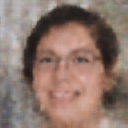

Tst Recon example:


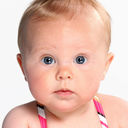

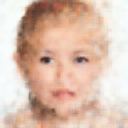

Generated example:


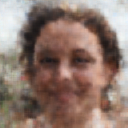

Epoch 27/300, Train Loss: 31686.9076, Test loss: 32162.7168
Trn Recon example:


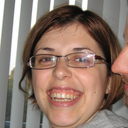

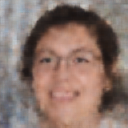

Tst Recon example:


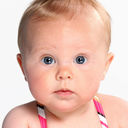

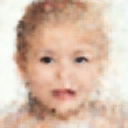

Generated example:


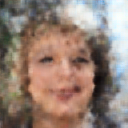

Epoch 28/300, Train Loss: 31679.1163, Test loss: 32170.3320
Trn Recon example:


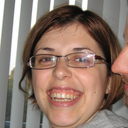

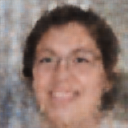

Tst Recon example:


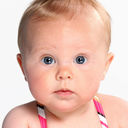

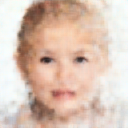

Generated example:


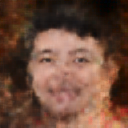

Epoch 29/300, Train Loss: 31672.1202, Test loss: 32169.5176
Trn Recon example:


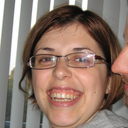

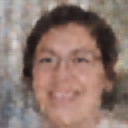

Tst Recon example:


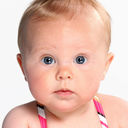

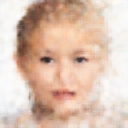

Generated example:


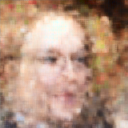

KeyboardInterrupt: 

In [65]:
# time to train our VAE!

cvae.train()
for epoch in range(num_epochs):
    train_loss = 0
    for data in dataloader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae(data)
        loss = vae_loss(recon_batch, data, mu, logvar, criterion)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    test_loss = eval_tst_vae_loss(cvae,criterion)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(dataloader.dataset):.4f}, Test loss: {test_loss:.4f}")
    print("Trn Recon example:")
    show_example(cvae)
    print("Tst Recon example:")
    show_example(cvae, dataset=tst_dataset)
    print("Generated example:")
    generate_samples_from_vae(cvae,num_samples=1)
    cvae.train() # because the sample/example functions go into cvae.eval()
    num_epochs_completed += 1

In [66]:
eval_tst_vae_loss(cvae,criterion)

tensor(32173.9219, device='cuda:0')

Trn Recon example(s):


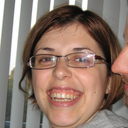

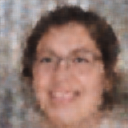

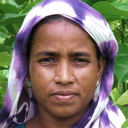

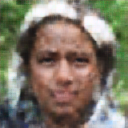

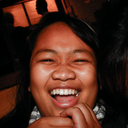

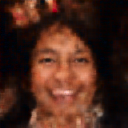

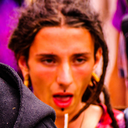

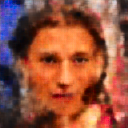

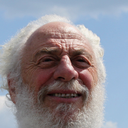

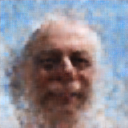

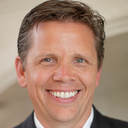

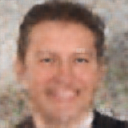

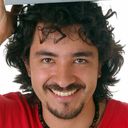

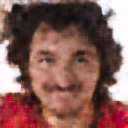

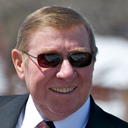

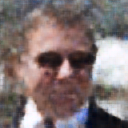

Tst Recon example(s):


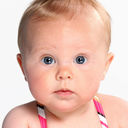

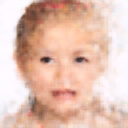

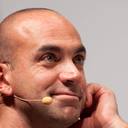

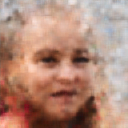

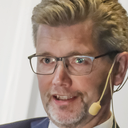

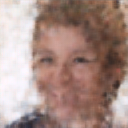

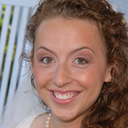

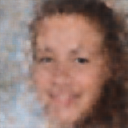

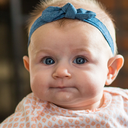

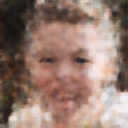

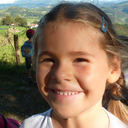

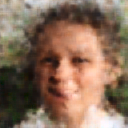

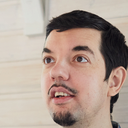

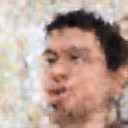

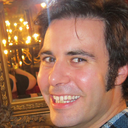

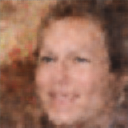

Generated example(s):


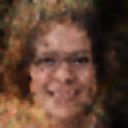

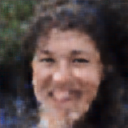

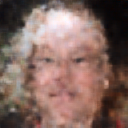

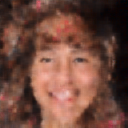

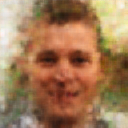

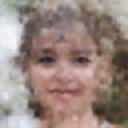

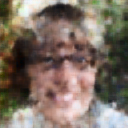

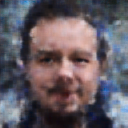

In [67]:
# save the model
test_loss = eval_tst_vae_loss(cvae,criterion)
savedir = f"latent_dim_{latent_dim}_tst_loss_{test_loss:.4f}_epochs_{num_epochs_completed}_beta_{beta}"
path_to_savedirs = os.path.join('.','saved_models','ColorVAE')
savedirpath = os.path.join(path_to_savedirs,savedir)
if savedir not in os.listdir(path_to_savedirs):
    os.mkdir(savedirpath)
savepath = os.path.join(savedirpath,"state_dict.pth")
torch.save(cvae.state_dict(), savepath)

# save some example images
num_examples_to_save = 8
print("Trn Recon example(s):")
trn_recon_examples = [show_example(cvae,idx = n,dataset=dataset) for n in range(num_examples_to_save)]
print("Tst Recon example(s):")
tst_recon_examples = [show_example(cvae,idx = n, dataset=tst_dataset) for n in range(num_examples_to_save)]
print("Generated example(s):")
generated_examples = generate_samples_from_vae(cvae,num_samples=num_examples_to_save)

reconpath = os.path.join(savedirpath,'recon')
if not 'recon' in os.listdir(savedirpath):
    os.mkdir(reconpath)
if not 'tst' in os.listdir(reconpath):
    os.mkdir(os.path.join(reconpath,'tst'))
    
if not 'trn' in os.listdir(reconpath):
    os.mkdir(os.path.join(reconpath,'trn'))
    
if not 'generated' in os.listdir(savedirpath):
    os.mkdir(os.path.join(savedirpath,'generated'))
for i in range(num_examples_to_save):
    trn_recon_examples[i]['original'].save(os.path.join(reconpath, 'trn', f"example_{i}_original.png"))
    trn_recon_examples[i]['recon'].save(os.path.join(reconpath, 'trn', f"example_{i}_recon.png"))
    tst_recon_examples[i]['original'].save(os.path.join(reconpath, 'tst', f"example_{i}_original.png"))
    tst_recon_examples[i]['recon'].save(os.path.join(reconpath, 'tst', f"example_{i}_recon.png"))
    generated_examples[i].save(os.path.join(savedirpath, 'generated', f"example_{i}.png"))

In [ ]:
generate_samples_from_vae(cvae,num_samples=10)